# NOTE: Make a copy of this notebook by clicking on "File" -> "Save a copy in Drive"



Install Required Packages

In [ ]:
! pip install datasets transformers==4.40.0 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [ ]:
import transformers

print(transformers.__version__)

4.40.0


# Train a language model

Causal language modeling: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token `i` when trying to predict the token `i+1` in the sentence.


## Preparing the dataset

We will use the `Wikitext 2` dataset as an example. You can load it very easily with the 'datasets' library and use with any dataset hosted on [Huggingface Datasets](https://huggingface.co/datasets) or use your own files.

In [ ]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

To access an actual element, you need to select a split first, then give an index:

In [ ]:
datasets["train"][10]

{'text': ' The game \'s battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters \' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
import time
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

,text
0,"A distinguishing feature of the Sclerodermatineae is the diversity of morphologies within the group . The hymenomycete genera Boletinellus , Gyroporus , and Phlebopus are typical boletes with a cap and stipe . However , each of the gasteroid Sclerodermatineae has a distinct morphology . Species of Astraeus have an "" earthstar "" morphology where the outer peridium peels back in sections . The gleba of Pisolithus is partitioned into hundreds of membranous chambers . Scleroderma is a simple puffball with a thin outer skin and a powdery gleba at maturity . Diplocystis and Tremellogaster are each distinct in their morphologies : the former comprises compound fruit bodies each with 3 – 60 spore sacs crowded together , while the latter forms a roughly spherical sporocarp with a thick multi @-@ layered peridium . Calostoma ( Greek for "" pretty mouth "" ) is morphologically distinct from other gasteroid members , having a fruit body that forms a globed , spore @-@ bearing head composed of a three @-@ layered peridium . About two @-@ thirds of Sclerodermatineae species have a gasteroid morphology , although this may be an underestimate due to the existence of cryptic species that have yet to be formally described . For example , studies of the gasteroid genera Astraeus and Pisolithus indicate the existence of numerous cryptic taxa . \n"
1,""" Jumpin ' , Jumpin ' "" \n"
2,= = Music = = \n
3,"Derfflinger and Lützow were 210 m ( 689 ft 0 in ) long at the waterline and 210 @.@ 40 m ( 690 ft 3 in ) long overall . Hindenburg was slightly longer , at 212 @.@ 50 m ( 697 ft 2 in ) at the waterline and 212 @.@ 80 m ( 698 ft 2 in ) overall . All three ships had a beam of 29 m ( 95 ft 2 in ) , and a draft of between 9 @.@ 20 m ( 30 ft 2 in ) forward and 9 @.@ 57 m ( 31 ft 5 in ) aft . The first two ships were designed to displace 26 @,@ 600 tonnes ( 26 @,@ 200 long tons ) with a standard load , and up to 31 @,@ 200 tonnes ( 30 @,@ 700 long tons ) at combat weight . Hindenburg displaced slightly more , at 26 @,@ 947 tonnes ( 26 @,@ 521 long tons ) standard and 31 @,@ 500 tonnes ( 31 @,@ 000 long tons ) fully laden . The ships ' hulls were constructed from longitudinal steel frames , over which the outer hull plates were riveted . Derfflinger 's hull contained 16 watertight compartments , though Lützow and Hindenburg had an additional seventeenth compartment . All three ships had a double bottom that ran for 65 % of the length of the hull . This was a decrease from preceding German battlecruisers , which had a double bottom for at least 75 % of the hull . \n"
4,
5,= = = Overall = = = \n
6,= = Construction = = \n
7,"Michael K. Hanna , a Democrat , represents the 76th District , which includes Lock Haven , in the Pennsylvania House of Representatives . Joseph B. Scarnati III , a Republican , represents Lock Haven as part of the 25th District of the Pennsylvania State Senate . \n"
8,"The next day , Isabella misses a meeting she set up with Rook , and does not return to the class . Through Amie texts and wall posts , the other students insinuate that she committed suicide , while the school is unable to provide Rook with any contact information for her . Class continues without her , and a little while later Arianna , if the player rejected her earlier in the game , makes another attempt to have a relationship with Rook . The player may choose to accept or reject her again . Through Amie , Rook learns that both Charlotte and Kendall wish to resume their relationship , and can influence Charlotte to try again or not , which changes whether or not they get back together . Taylor jealously and unsuccessfully tries to drive a wedge between Nolan and Akira . \n"
9,= Transit of Venus = \n


As we can see, some of the texts are a full paragraph of a Wikipedia article while others are just titles or empty lines.

## Causal Language modeling

For causal language modeling (CLM) we are going to take all the texts in our dataset and concatenate them after they are tokenized. Then we will split them in examples of a certain sequence length. This way the model will receive chunks of contiguous text that may look like:
```
part of text 1
```
or
```
end of text 1 [BOS_TOKEN] beginning of text 2
```
depending on whether they span over several of the original texts in the dataset or not. The labels will be the same as the inputs, shifted to the left.

We will use the [`gpt2`](https://huggingface.co/gpt2) architecture for this example. You can pick any of the checkpoints listed [here](https://huggingface.co/models?filter=causal-lm) instead. For the tokenizer, you can replace the checkpoint by the one you trained yourself.

In [ ]:
model_checkpoint = "gpt2"
tokenizer_checkpoint = "sgugger/gpt2-like-tokenizer"

To tokenize all our texts with the same vocabulary that was used when training the model, we have to download a pretrained tokenizer. This is all done by the `AutoTokenizer` class:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/396k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/678k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

We can now call the tokenizer on all our texts. This is very simple, using the [`map`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map) method from the Datasets library. First we define a function that call the tokenizer on our texts:

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

Then we apply it to all the splits in our `datasets` object, using `batched=True` and 4 processes to speed up the preprocessing. We won't need the `text` column afterward, so we discard it.

In [ ]:
tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

If we now look at an element of our datasets, we will see the text have been replaced by the `input_ids` the model will need:

In [ ]:
tokenized_datasets["train"][1]

{'input_ids': [238, 8576, 9441, 2987, 238, 252],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

Now for the harder part: we need to concatenate all our texts together then split the result in small chunks of a certain `block_size`. To do this, we will use the `map` method again, with the option `batched=True`. This option actually lets us change the number of examples in the datasets by returning a different number of examples than we got. This way, we can create our new samples from a batch of examples.

First, we grab the maximum length our model was pretrained with. This might be a big too big to fit in your GPU RAM, so here we take a bit less at just 128.

In [ ]:
# block_size = tokenizer.model_max_length
block_size = 128

Then we write the preprocessing function that will group our texts:

In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

First note that we duplicate the inputs for our labels. This is because the model of the 🤗 Transformers library apply the shifting to the right, so we don't need to do it manually.

Also note that by default, the `map` method will send a batch of 1,000 examples to be treated by the preprocessing function. So here, we will drop the remainder to make the concatenated tokenized texts a multiple of `block_size` every 1,000 examples. You can adjust this behavior by passing a higher batch size (which will also be processed slower). You can also speed-up the preprocessing by using multiprocessing:

In [ ]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/4358 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/36718 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3760 [00:00<?, ? examples/s]

And we can check our datasets have changed: now the samples contain chunks of `block_size` contiguous tokens, potentially spanning over several of our original texts.

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' the " Nameless ", a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven ". \n The game began development in 2010, carrying over a large portion of the work done on Valkyria Chronicles II. While it retained the standard features of the series, it also underwent multiple adjustments, such as making the game more forgiving for series newcomers. Character designer Raita Honjou and composer Hitoshi Sakimoto both returned from previous entries, along with Valkyria Chronicles II director Takeshi Ozawa. A large'

Now that the data has been cleaned, we're ready to instantiate our `Trainer`. First we create the model using the same config as our checkpoint, but initialized with random weights:

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

config = AutoConfig.from_pretrained(model_checkpoint)
model = AutoModelForCausalLM.from_config(config)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

And we will needsome `TrainingArguments`:

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
print(f"{model_checkpoint}-wikitext2")

gpt2-wikitext2


In [ ]:
training_args = TrainingArguments(
    f"{model_checkpoint}-wikitext2",
    evaluation_strategy = "epoch",
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False
)

In [ ]:
def pre_process( dataset, take_percent = 1):
    totalSamples = len(dataset)
    print(f"Using {take_percent}% of total {totalSamples} samples" )
    return (dataset.select(range(int((take_percent/100)*totalSamples))))



We pass along all of those to the `Trainer` class:

In [ ]:
take_percent = 10
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= pre_process( lm_datasets["train"], take_percent=take_percent) ,
    eval_dataset=pre_process( lm_datasets["validation"], take_percent=take_percent)
)

Using 10% of total 17991 samples
Using 10% of total 1934 samples


In [ ]:
import time
import math

And we can train our model:

In [ ]:
start_time = time.time()
trainer.train()
training_runtime = time.time() - start_time
print("Training completed in (seconds) : ", training_runtime)

Epoch,Training Loss,Validation Loss
1,No log,7.542471
2,No log,7.373659


Training completed in (seconds) :  149.23629021644592


In [ ]:
eval_results = trainer.evaluate()
print(f"Cross-Entropy Loss: {eval_results['eval_loss']:.2f}")
print(f"Perplexity Loss: {math.exp(eval_results['eval_loss']):.2f}")

Cross-Entropy Loss: 9.35
Perplexity Loss: 11507.77


For More Details:
1. https://huggingface.co/docs/transformers/v4.40.0/en/main_classes/pipelines#transformers.TextGenerationPipeline
2. https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForCausalLM

#**Quiz**

#**Quiz**

Submit the answers to the quesetions on this google form: https://forms.gle/AnQwnrRt4tPY6szY7

## 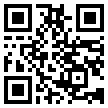


1. Get Training Times for 10% , 20%, 30% of datasets without changing any other parameters. Your 100% dataset has approximately 2 million words, Meta has recently reported using a dataset of approx 11.5 trillion words. How much training time would it take to train your model with Meta's dataset? Assume you would use the same hardware, same model, and same parameters as your current notebook.   
Hint: change `num_train_epochs` in  `training_args`


2. Get Cross-Entropy Loss values for 1, 3, 5 epochs and using 1% of dataset without changing any other parameters. How many epochs would it take to get Cross-Entropy Loss of 3 ?  
Hint: change `take_percent` in  `Trainer`

3. How would you compare the accuracy of a model which generated text "This is a white dog " but the expected text was "This is a green dog" ?

